# Generic scikit-learn classifier

run any scikit-learn compatible classifier or list of classifiers
### **Function steps** :
> **Generate a scikit-learn model configuration** using the `model_pkg_class` parameter
>   * input a package and class name, for example, `sklearn.linear_model.LogisticRegression`  
>   * mlrun will find the class and instantiate a copy using default parameters  
>   * You can modify both the model class instantiator and the fit methods  (other functions could be similarly modified)

> **Get a sample of data** from a data source
>  * select all rows using -1
>  * select a random sample of rows using a negative integer
>  * select consecutive rows using a positive integer

> **Split the data** into train, validation, and test sets 
>  * the test set is saved as an artifact and never seen again until testing
>  * WIP: this will be parametrized to produce cross-validator splits (one way of performing CV)

> **Train the model** using xgboost in one of its flavours (dask, gpu, mpi...)

> **Pickle / serialize the model**
>  * models can be pickled or saved as json (a newer xgboost format)

> **Evaluate the model**
>  * a custom evaluator can be provided, see function doc for details

### **Example steps**

1. [Data exploration](#Data-exploration)
2. [Importing the function](#Importing-the-function)
3. [Setup sklearn trainer parameters](#Setup-sklearn-trainer-parameters)
4. [Set model parameters and run locally](#Set-model-parameters-and-run-locally)
5. [Set model parameters and run remotely](#Set-model-parameters-and-run-remotely)

### **Envioronment Setup**

In [1]:
# upload environment variables from env file if exists
import os,mlrun
   
# Specify path
path = "/tmp/examples_ci.env"
   
if os.path.exists(path):
    env_dict = mlrun.set_env_from_file(path, return_dict=True)


### **Create mlrun Project**

In [2]:
# create the new project
project_name = 'sklearn-classifier-example'

# Initialize the MLRun project object
project = mlrun.get_or_create_project(project_name, context="./", user_project=True)

> 2022-12-04 11:14:48,495 [info] loaded project sklearn-classifier-example from MLRun DB


### **Data exploration**

In [3]:
# Dataset is generated from sklearn's load_iris
from sklearn.datasets import load_iris

data = load_iris()
print(data['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [4]:
import pandas as pd

data_url = 'https://s3.wasabisys.com/iguazio/data/function-marketplace-data/sklearn_classifier/iris_dataset.csv'
df = pd.read_csv(data_url)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### **Importing the function**

In [5]:
fn = mlrun.import_function("hub://sklearn_classifier")
fn.apply(mlrun.auto_mount())

### **Setup sklearn trainer parameters**

the following task paramaters are common to all runs

In [6]:
task_params = {
    #"name" : "sklearn classifier",
    "params" : {
        "sample"             : -1,
        "test_size"          : 0.30,
        "train_val_split"    : 0.70,
        "random_state"       : 1,
        "n_jobs"             : -1,
        "plots_dest"         : "plots-p",
        "models_dest"        : 'sklearn-clfmodel'}}

models = [
    "sklearn.ensemble.RandomForestClassifier", 
    "sklearn.linear_model.LogisticRegression",
    "sklearn.ensemble.AdaBoostClassifier"
]

### **Set model parameters and run locally**

* loop over a list of candidate models, update the task and run a local trainer for that model  
* optionally customize some parameters for each model
* accumulate the resulting artifacts in a list of dicts for debugging and testing purposes  

please note that the following parameters have been chosen without regard to optimization and model tuning

> 2022-12-04 13:05:48,791 [info] starting run training uid=5a3512561063436abee4e5cb7c5a1c3b DB=http://mlrun-api:8080
> 2022-12-04 13:05:54,425 [info] best iteration=2, used criteria max.accuracy


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
sklearn-classifier-example-avia,...7c5a1c3b,0,Dec 04 13:05:48,completed,training,v3io_user=aviakind=owner=avia,dataset,label_column=label,best_iteration=2accuracy=0.96875test-error=0.03125auc-micro=0.95458984375auc-weighted=0.965958605664488f1-score=0.9582027168234065precision_score=0.9444444444444445recall_score=0.9777777777777779,test_setconfusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclassmodeliteration_resultsparallel_coordinates


> 2022-12-04 13:05:55,040 [info] run executed, status=completed


<Figure size 432x288 with 0 Axes>

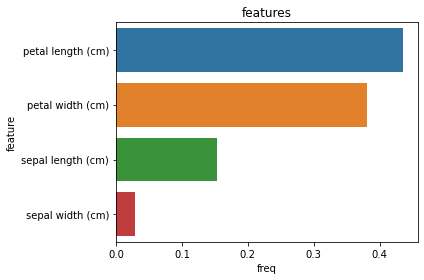

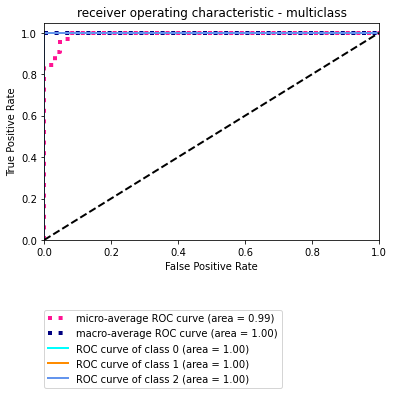

<Figure size 432x288 with 0 Axes>

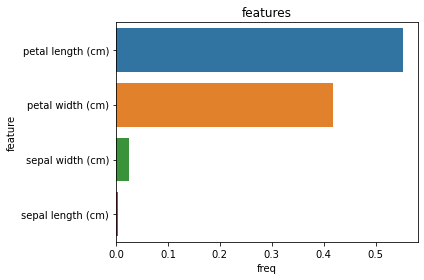

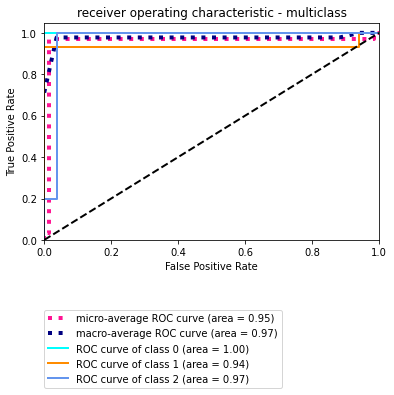

<Figure size 432x288 with 0 Axes>

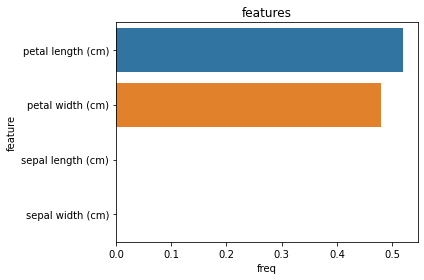

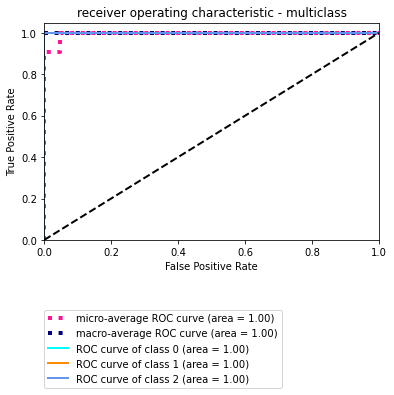

In [28]:
# Import the Sklearn classifier function from the functions hub
classifier_fn = mlrun.import_function('hub://sklearn-classifier')
training_params = {"model_name": ['skc_rf', 
                                  'skc_xgboost', 
                                  'skc_fraud_adaboost'],
              
              "model_pkg_class": ['sklearn.ensemble.RandomForestClassifier',
                                  'sklearn.ensemble.GradientBoostingClassifier',
                                  'sklearn.ensemble.AdaBoostClassifier']}
# Define the training task, including our feature vector, label and hyperparams definitions
train_task = mlrun.new_task('training', 
                      inputs={'dataset': data_url},
                      params={'label_column': 'label'}
                     )

train_task.with_hyper_params(training_params, strategy='list', selector='max.accuracy')

# Run training
classifier_run  = classifier_fn.run(train_task, local=True)

### **Set model parameters and run remotely**

In [26]:
classifier_run_remotely  = classifier_fn.run(train_task, local=False)

> 2022-12-04 13:04:08,607 [info] starting run training uid=add744da81b542a99aa841ebf1e2b21d DB=http://mlrun-api:8080
> 2022-12-04 13:04:08,804 [info] Job is running in the background, pod: training-xszc7
> 2022-12-04 13:04:20,376 [info] best iteration=2, used criteria max.accuracy
> 2022-12-04 13:04:20,975 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
sklearn-classifier-example-avia,...f1e2b21d,0,Dec 04 13:04:12,completed,training,v3io_user=aviakind=jobowner=aviamlrun/client_version=1.2.0-rc22,dataset,label_column=label,best_iteration=2accuracy=0.96875test-error=0.03125auc-micro=0.95556640625auc-weighted=0.9689542483660131f1-score=0.9582027168234065precision_score=0.9444444444444445recall_score=0.9777777777777779,test_setconfusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclassmodeliteration_resultsparallel_coordinates


> 2022-12-04 13:04:28,220 [info] run executed, status=completed


### **Show the iteration results**

[Back to the top](#Generic-scikit-learn-classifier)

In [27]:
classifier_run_remotely.artifact('iteration_results').show()

> 2022-12-04 13:04:20,376 [info] best iteration=2, used criteria max.accuracy
> 2022-12-04 13:04:20,975 [info] run executed, status=completed

final state: completed


,state,iter,param.label_column,param.model_name,param.model_pkg_class,output.accuracy,output.test-error,output.auc-micro,output.auc-weighted,output.f1-score,output.precision_score,output.recall_score
0,completed,1,label,skc_rf,sklearn.ensemble.RandomForestClassifier,0.90625,0.09375,0.990967,0.997923,0.886040,0.875000,0.933333
1,completed,2,label,skc_xgboost,sklearn.ensemble.GradientBoostingClassifier,0.96875,0.03125,0.955566,0.968954,0.958203,0.944444,0.977778
2,completed,3,label,skc_fraud_adaboost,sklearn.ensemble.AdaBoostClassifier,0.90625,0.09375,0.995605,1.000000,0.886040,0.875000,0.933333
